In this notebook we try to model our data with a decision tree. In particular, we try to see to what extent a decision tree can predict if a video gets at least 10,000 views. 

As discussed before, we don't expect great performance of this model. That is, we do not believe our targets are fully explained by our features or any features that can be extracted from our data set. However, we hope to understand something about the data from looking at these models. For example, we found that we prediced whether a video gets at least 10,000 views with an accuracy score of 0.6165 which helps us understand to what extent our targets are explainable by our data. 

In [92]:
## Import packages
import pandas as pd
import sklearn as skislopes
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier
from sklearn.metrics import accuracy_score

In [93]:
## Import packages
import pandas as pd
import sklearn as skislopes
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier
from sklearn.metrics import accuracy_score

In [94]:

df = pd.read_csv('../data/new/no_early_dates_all_features_train.csv')
df.columns

df['datetime'] = pd.to_datetime(df['date'])

df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek  # 0 is Monday, 6 is Sunday
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df["hashtags"] = df["hashtag_indicator"]


In [95]:
#First 80-20 Train Test Split, before the EDA

df_train, df_test = train_test_split(df, shuffle = True, test_size = .2, random_state = 420)
df_tt, df_ho = train_test_split(df_train, shuffle = True, test_size = .2, random_state = 420)

<Axes: >

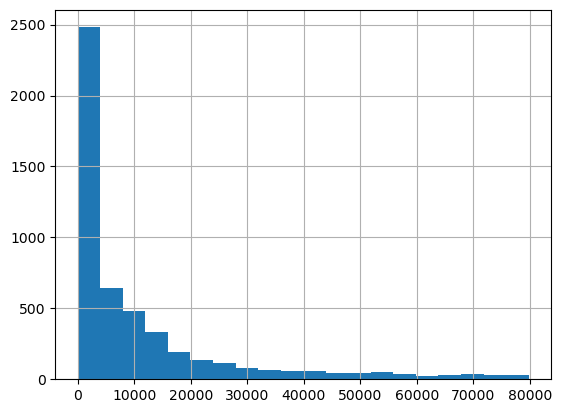

In [96]:
#10k views seems to be a reasonable cut off point for a decent amount of views, it's a little over the median
df_train.query("viewCount < 8e4")["viewCount"].hist(bins=20)

# Selecting Features

In [98]:
def add_features(df):
    df["len_channel_description"] = df["channelDescription"].str.len()
    df["len_channel_username"] = df["channelUsername"].str.len()
    df["len_title"] = df["title"].str.len()

    df["has_over_10k_views"] = df.eval("viewCount >= 10000").astype(int)
    return df

In [99]:
df_tt_with_features = add_features(df_tt)
df_ho_with_features = add_features(df_ho)

In [100]:
features = ["month", "day_of_week", "hour", "len_title","duration_in_seconds",
            "hashtags", "popular_brand", "self_ref", "korean", "prime_hour"]

responder = "has_over_10k_views"

In [101]:
X_train = df_tt_with_features[features].values
y_train = df_tt_with_features[responder].values

In [102]:
tree_clf = DecisionTreeClassifier(max_depth=10)

## fit the classifier
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [103]:
y_tt_preds = tree_clf.predict(df_tt_with_features[features])
y_ho_preds = tree_clf.predict(df_ho_with_features[features])

C:\Users\arubi\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\arubi\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


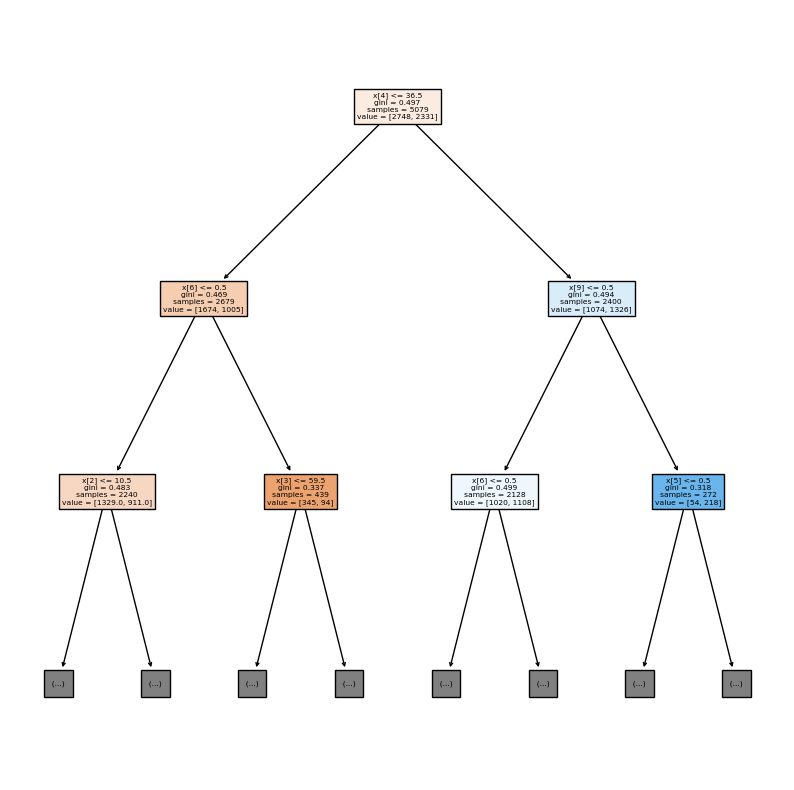

In [104]:
## Plot the fitted tree
plt.figure(figsize = (10,10))
tree.plot_tree(tree_clf, filled = True, max_depth=2)
plt.show()

In [105]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true=df_tt_with_features[responder], y_pred=y_tt_preds))
print(accuracy_score(y_true=df_ho_with_features[responder], y_pred=y_ho_preds))

0.7686552470958851
0.6165354330708661


In [106]:
df_tt_with_features["model_predictions"] = y_tt_preds

<Axes: >

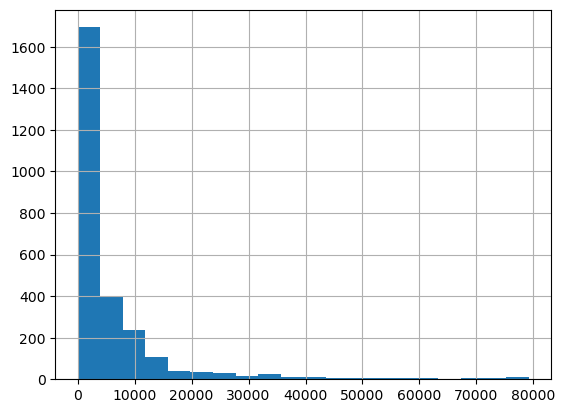

In [107]:
df_tt_with_features.query("viewCount < 8e4 and model_predictions < 0.5")["viewCount"].hist(bins=20)

<Axes: >

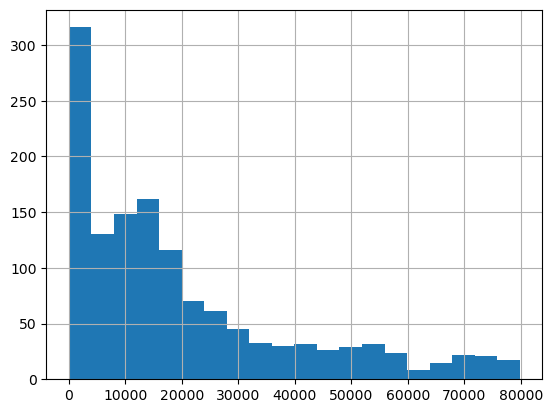

In [108]:
df_tt_with_features.query("viewCount < 8e4 and model_predictions > 0.5")["viewCount"].hist(bins=20)

In [109]:
forest = RandomForestRegressor(
    n_estimators=500,
    max_depth=25,
    min_samples_leaf=3,
)

forest_responder = "viewCount"
y_tt_forest = df_tt_with_features[forest_responder].values


In [110]:
## Fit the model
forest.fit(X_train, y_tt_forest)

RandomForestRegressor(max_depth=25, min_samples_leaf=3, n_estimators=500)

In [111]:
rf_tt_preds = forest.predict(X_train)
rf_ho_preds = forest.predict(df_ho_with_features[features])
df_tt_with_features["rf_preds"] = rf_tt_preds
df_ho_with_features["rf_preds"] = rf_ho_preds

C:\Users\arubi\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [112]:
from sklearn.metrics import r2_score

In [113]:
r2_score(y_true=df_tt_with_features["viewCount"], y_pred=df_tt_with_features["rf_preds"])

0.50567263400328

In [114]:
r2_score(y_true=df_ho_with_features["viewCount"], y_pred=df_ho_with_features["rf_preds"])

0.08380959341536032

<Axes: xlabel='rf_preds', ylabel='viewCount'>

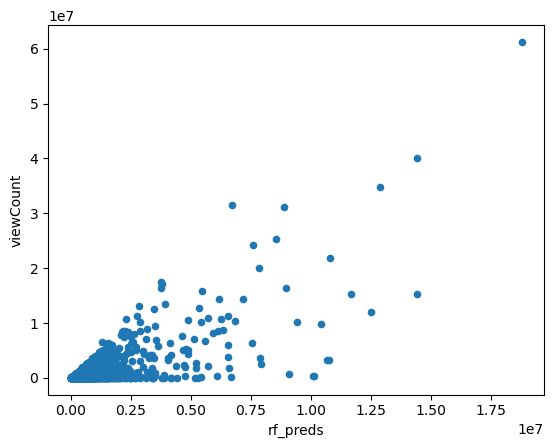

In [115]:
df_tt_with_features.plot.scatter("rf_preds", "viewCount")

<Axes: xlabel='rf_preds', ylabel='viewCount'>

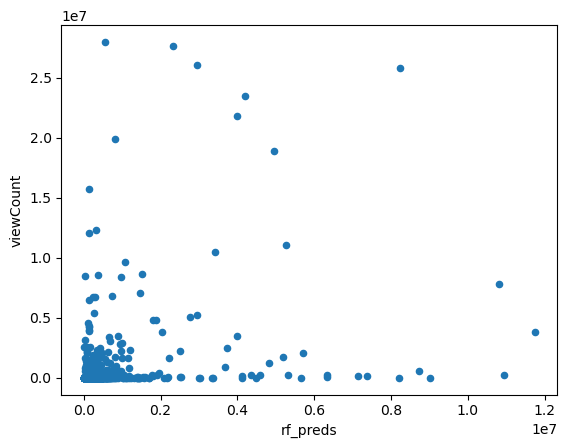

In [116]:
df_ho_with_features.plot.scatter("rf_preds", "viewCount")